In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

import pickle
%matplotlib inline
print("PyTorch Version: ",torch.__version__)
import torchvision
print("Torchvision Version: ",torchvision.__version__)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


PyTorch Version:  0.4.0
Torchvision Version:  0.2.1


In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [3]:
!nvidia-smi

Tue Jun 18 11:35:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.24                 Driver Version: 396.24                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:02:00.0 Off |                  N/A |
| 30%   41C    P8    11W / 180W |   5977MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:81:00.0 Off |                  N/A |
| 27%   38C    P8     7W / 180W |     10MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [4]:
torch.cuda.memory_allocated()

865280

In [5]:
torch.cuda.empty_cache()

## Utility functions

In [6]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class FeaturesDataset(Dataset):
    
    def __init__(self,features_list,labels_list):
        self.features_list = features_list
        self.labels_list = labels_list
        
    def __getitem__(self,index):
        return (self.features_list[index],self.labels_list[index])
    
    def __len__(self):
        return len(self.labels_list)
    
def fit(epoch, model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    cummulative_loss = 0.0
    cummulative_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        cummulative_loss += F.cross_entropy(output,target,size_average=False).data[0]
        preds = output.data.max(dim=1,keepdim=True)[1]
        cummulative_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = cummulative_loss/len(data_loader.dataset)
    accuracy = 100. * cummulative_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss} and {phase} accuracy is {cummulative_correct}/{len(data_loader.dataset)}{accuracy}')
    return loss,accuracy

## Creating PyTorch datasets

In [7]:
transform_data = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.30, 0.40, 0.40], [0.20, 0.20, 0.20])
    ])

In [8]:
train_dataset = ImageFolder('../Chapter03/Dog-Cat-Classifier/Data/Train_Data/train/',transform=transform_data)
validation_dataset = ImageFolder('../Chapter03/Dog-Cat-Classifier/Data/Train_Data/valid/',transform=transform_data)
classes=2

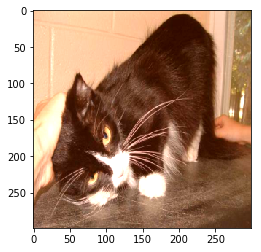

In [9]:
imshow(train_dataset[150][0])

## Creating data loader for training and validation datasets

In [10]:
training_data_loader = DataLoader(train_dataset,batch_size=32,shuffle=False,num_workers=4)
validation_data_loader = DataLoader(validation_dataset,batch_size=32,shuffle=False,num_workers=4)

## Creating ResNet 34 model

In [11]:
resnet_model = resnet34(pretrained=True)

if is_cuda:
    resnet_model = resnet_model.cuda()

In [12]:
m = nn.Sequential(*list(resnet_model.children())[:-1])

## Extracting Convolutional features

In [13]:
# Stores the labels of the train data
training_data_labels = [] 

# Stores the pre convoluted features of the train data
training_features = [] 

#Iterate through the train data and store the calculated features and the labels
for d,la in training_data_loader:
    with torch.no_grad(): # To help with memory issues
        o = m(Variable(d.cuda()))
        o = o.view(o.size(0),-1)
        training_data_labels.extend(la)
        training_features.extend(o.cpu().data)

#For validation data

#Iterate through the validation data and store the calculated features and the labels

validation_data_labels = []
validation_features = []
for d,la in validation_data_loader:
    with torch.no_grad(): # To help with memory issues
        o = m(Variable(d.cuda()))
        o = o.view(o.size(0),-1)
        validation_data_labels.extend(la)
        validation_features.extend(o.cpu().data)

## Creating train and validation feature dataset

In [14]:
#Creating dataset for train and validation
train_features_dataset = FeaturesDataset(training_features,training_data_labels)
validation_features_dataset = FeaturesDataset(validation_features,validation_data_labels)

#Creating data loader for train and validation
train_features_loader = DataLoader(train_features_dataset,batch_size=64,shuffle=True)
validation_features_loader = DataLoader(validation_features_dataset,batch_size=64)

## A Fully connected network

In [15]:
class FullyConnectedLinearModel(nn.Module):
    
    def __init__(self,input_size,output_size):
        super().__init__()
        self.fc = nn.Linear(input_size,output_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [16]:
fully_connected_in_size = 8192

In [17]:
fc = FullyConnectedLinearModel(fully_connected_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [18]:
optimizer = optim.Adam(fc.parameters(),lr=0.0001)

## Train and validate the model

In [19]:
train_losses , train_accuracy = [],[]
validation_losses , validation_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,fc,train_features_loader,phase='training')
    validation_epoch_loss , validation_epoch_accuracy = fit(epoch,fc,validation_features_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    validation_losses.append(validation_epoch_loss)
    validation_accuracy.append(validation_epoch_accuracy)

training loss is 0.8001697063446045 and training accuracy is 601/114952
validation loss is 0.6819716095924377 and validation accuracy is 150/25060
training loss is 0.698416531085968 and training accuracy is 669/114958
validation loss is 0.61382657289505 and validation accuracy is 170/25068
training loss is 0.5987679958343506 and training accuracy is 796/114969
validation loss is 0.5830464959144592 and validation accuracy is 176/25070
training loss is 0.5694668889045715 and training accuracy is 822/114971
validation loss is 0.5522308349609375 and validation accuracy is 187/25074
training loss is 0.5458188056945801 and training accuracy is 866/114975
validation loss is 0.5322710275650024 and validation accuracy is 190/25076
training loss is 0.5245423913002014 and training accuracy is 870/114975
validation loss is 0.5251204371452332 and validation accuracy is 186/25074
training loss is 0.520514726638794 and training accuracy is 867/114975
validation loss is 0.5525538325309753 and validati